# Case with multiple risky Assets

# 1. Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
from numpy.linalg import inv
from numpy.linalg import det
from pymarkowitz import *
import bt

# 2. Generate Data

## 2.1 Load Data

In [2]:
# Read and print the stock tickers that make up S&P500
tickers = pd.read_html(
    'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

list_symb = tickers.Symbol.to_list()
list_symb.remove('BRK.B')
list_symb.remove('BF.B')

print(tickers.head())

# Get the data for this tickers from yahoo finance
data = yf.download(list_symb,'1992-6-30', '2022-6-30', interval='1mo', auto_adjust=True)['Close']
print(data.head())
data_n = data

  Symbol     Security SEC filings  GICS Sector         GICS Sub-Industry  \
0    MMM           3M     reports  Industrials  Industrial Conglomerates   
1    AOS  A. O. Smith     reports  Industrials         Building Products   
2    ABT       Abbott     reports  Health Care     Health Care Equipment   
3   ABBV       AbbVie     reports  Health Care           Pharmaceuticals   
4   ABMD      Abiomed     reports  Health Care     Health Care Equipment   

     Headquarters Location Date first added      CIK      Founded  
0    Saint Paul, Minnesota       1976-08-09    66740         1902  
1     Milwaukee, Wisconsin       2017-07-26    91142         1916  
2  North Chicago, Illinois       1964-03-31     1800         1888  
3  North Chicago, Illinois       2012-12-31  1551152  2013 (1888)  
4   Danvers, Massachusetts       2018-05-31   815094         1981  
[*********************100%***********************]  501 of 501 completed
             A  AAL  AAP     AAPL  ABBV  ABC    ABMD       ABT

## 2.2 Manipulate Data

### 2.2.1 Drop all non-values

In [3]:
data = data.dropna(0,"all")
data = data.dropna(1,"any",thresh=360)
data = data.dropna(0)

/var/folders/49/4kqg08kn0990xympcdr529dh0000gn/T/ipykernel_6432/2370537963.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  data = data.dropna(0,"all")
/var/folders/49/4kqg08kn0990xympcdr529dh0000gn/T/ipykernel_6432/2370537963.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  data = data.dropna(1,"any",thresh=360)
/var/folders/49/4kqg08kn0990xympcdr529dh0000gn/T/ipykernel_6432/2370537963.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  data = data.dropna(0)


### 2.2.2 Split in training and testing data

In [317]:
data1 = data.iloc[:120]
data2 = data.iloc[120:240]

### 2.2.3 Compute Returns

In [318]:
prices = data1.to_numpy()
prices2 = data2.to_numpy()
Returns = prices[1:,:]/prices[:-1,:]-1
Returns2 = prices2[1:,:]/prices2[:-1,:]-1

# 3. Derivatives of Cost Function

In section 7.4, we derived the discrteized cost function:

\begin{align*}
    C(\theta, \varphi)=\frac{1}{2} \sum_{\left(t_{i}, x_{i}\right) \in \mathcal{D}}\left(\dot{V}^{\theta}\left(t_{i}, x_{i}\right)+\lambda \int_{\mathbb{R}^d} \pi_{t_{i}}^{\varphi}(u) \ln \pi_{t_{i}}^{\varphi}(u) d u\right)^{2} \Delta t,
\end{align*}

Further, we computed its derivatives with respect to the parameters $\theta_1$, $\theta_2$, $\varphi_1$ and $\varphi_2$:

\begin{align}
\begin{split}
\frac{\partial C}{\partial \theta_{1}}&=\sum_{\left(t_{i}, x_{i}\right) \in \mathcal{D}}\bigg(\dot{V}^{\theta}\left(t_{i}, x_{i}\right)-\lambda\Big(\frac{d}{2}(1+\ln(\lambda\pi))-\ln(\text{det}(\varphi_1))+\varphi_2^\top\varphi_2(T-t_i)\Big)\bigg) \Delta t
\end{split}
\end{align}

\begin{align}
\frac{\partial C}{\partial \theta_{2}}&=\sum_{\left(t_{i}, x_{i}\right) \in \mathcal{D}}\bigg(\dot{V}^{\theta}\left(t_{i}, x_{i}\right)-\lambda\Big(\frac{d}{2}(1+\ln(\lambda\pi))-\ln(\text{det}(\varphi_1))+\varphi_2^\top\varphi_2(T-t_i)\Big)\bigg)\left(t_{i+1}^{2}-t_{i}^{2}\right)
\end{align}

In [6]:
def Deriv_Cost_Funct_Theta_1(theta,phi,dt,w,T,D,lam,d):
    
    ## Input: 
    # theta: Parameter (numpy array with shape (4,1))
    # phi: Parameter (list of numpy arrays with shape (d,d) and (d,1))
    # dt: time intervall (float)
    # w: Lagrange multiplier (float)
    # T: terminal time (float or int)
    # D: Set of samples (numpy array with shape (2,k) with k>1)
    # lam: Exploration weight (float or int)
    # d: number of risky assets (int)
    #
    ## Output: 
    # The derivative of the cost function with respect to theta_1
    
    # Size of set of samples
    n = D.shape[1]
    
    ## Derivative of cost function with respect to theta_1
    
    # Computation of first term by using cancelation
    Term1 = (D[1,-1]-w)**2*np.exp(-theta[3]*(T-D[0,-1]))-(D[1,0]-w)**2*np.exp(-theta[3]*(T-D[0,0]))
    
    # Computation of second term by using formula for partial sum of 1 + 2 + ... + n 
    # and also 1 + 4 + 9 + ... + n^2
    Term2 = theta[2]*dt**2*(n-1)*(n-1)+(n-1)*theta[1]*dt-lam*dt*((n-1)*(d/2*(1+np.log(np.pi*lam))-np.log(det(phi[0]))+np.dot(phi[1],phi[1])*T-np.dot(phi[1],phi[1])*dt*(n-2)/2))
    
    DCT1 = Term1 + Term2
    
    return DCT1

The next function is not used but stated for completeness.

In [7]:
def Deriv_Cost_Funct_Theta(theta,phi,dt,w,T,D,lam,d):
    
    ## Input: 
    # theta: Parameter (numpy array with shape (4,1))
    # phi: Parameter (list of numpy arrays with shape (d,d) and (d,1))
    # dt: time intervall (float)
    # w: Lagrange multiplier (float)
    # T: terminal time (float or int)
    # D: Set of samples (numpy array with shape (2,k) with k>1)
    # lam: Exploration weight (float or int)
    # d: number of risky assets (int)
    #
    ## Output: 
    # The derivative of the cost function with respect to theta_1 and theta_2
    
    # Size of set of samples
    n = D.shape[1]
    
    ## Derivative of cost function with respect to theta_1
    DCT1 = Deriv_Cost_Funct_Theta_1(theta,phi,dt,w,T,D,lam,d)
    
    ## Derivative of cost function with respect to theta_2
    
    # Auxiliary function
    f_D = list(map(lambda x: (x[1]-w)**2*np.exp(-Theta[3]*(T-x[0])), D.T))
    
    # Computation of remaining terms by using formula for partial sum of 1 + 2 + ... + n 
    # and also 1 + 4 + 9 + ... + n^2
    Term1 = 2*(-dt*sum(f_D[1:-1])+(D[1,-1]-w)**2*np.exp(-Theta[3]*(T-D[0,-1]))*D[0,-2]) #t0=0
    Term2 = 2*(Theta[2]*dt**3*(n-2)*(n-1)*((2*n-3)/3+1/2)+Theta[1]*dt**2*(n-2)*(n-1)/2)
    Term3 = -lam*dt**2*(n-2)*(n-1)*(d/2*(1+np.log(lam*np.pi))-np.log(det(phi[0]))+np.dot(phi[1],phi[1])*T-np.dot(phi[1],phi[1])*dt*(2*n-3)/3)
    
    DCT2 = DCT1*dt + Term1 + Term2 + Term3
    
    return np.array([DCT1,DCT2])

\begin{align}
\begin{split}
\frac{\partial C}{\partial \varphi_{1}}&=\sum_{\left(t_{i}, x_{i}\right) \in \mathcal{D}}\bigg(\dot{V}^{\theta}\left(t_{i}, x_{i}\right)-\lambda\Big(\frac{d}{2}(1+\ln(\lambda\pi))-\ln(\text{det}(\varphi_1))+\varphi_2^\top\varphi_2(T-t_i)\Big)\bigg) \Delta t \lambda (\varphi_1^{-1})^\top 
\end{split}
\end{align}


\begin{align}
\begin{split}
\frac{\partial C}{\partial \varphi_{2}}=\sum_{\left(t_{i}, x_{i}\right) \in \mathcal{D}}\bigg(\dot{V}^{\theta}\left(t_{i}, x_{i}\right)-\lambda\Big(\frac{d}{2}(1+\ln(\lambda\pi))-\ln(\text{det}(\varphi_1))+\varphi_2^\top\varphi_2(T-t_i)\Big)\bigg) \Delta t\cdot\bigg(-\frac{4\varphi_2}{d\Delta t}\Big(\left(x_{i+1}-w\right)^{2} e^{-\frac{2}{d} \varphi_{2}^\top\varphi_{2}\left(T-t_{i+1}\right)}\left(T-t_{i+1}\right)-\left(x_{i}-w\right)^{2} e^{-\frac{2}{d} \varphi_{2}^\top\varphi_{2}\left(T-t_{i}\right)}\left(T-t_{i}\right)\Big)-2\varphi_2\lambda\left(T-t_{i}\right)\bigg).
\end{split}
\end{align}

In [8]:
def Deriv_Cost_Funct_Phi(theta,phi,dt,w,T,D,lam,d):
    
    ## Input: 
    # theta: Parameter (numpy array with shape (4,1))
    # phi: Parameter (list of numpy arrays with shape (d,d) and (d,1))
    # dt: time intervall (float)
    # w: Lagrange multiplier (float)
    # T: terminal time (float or int)
    # D: Set of samples (numpy array with shape (2,k) with k>1)
    # lam: Exploration weight (float or int)
    # d: number of risky assets (int)
    #
    ## Output: 
    # The derivative of the cost function with respect to phi
    
    # Size of set of samples
    n = D.shape[1]
    
    ## Derivative of cost function with respect to theta_1
    DCT1 = Deriv_Cost_Funct_Theta_1(theta,phi,dt,w,T,D,lam,d)
    
    ## Derivative of cost function with respect to phi_0
    DCP0 = lam*inv(phi[0]).T*DCT1
    
    ## Derivative of cost function with respect to phi_1
    
    # Auxiliary function
    #f_D = list(map(lambda x: (x[1]-w)**2*np.exp(-theta[3]*(T-x[0])), D.T))
    
    # Value function
    f_x = lambda x: (x-w)**2
    f1_t = lambda t: np.exp(-theta[3]*(T-t))
    f2_t = lambda t: theta[2]*t**2+theta[1]*t+theta[0]
    
    V = f_x(D[1,:])*f1_t(D[0,:])+f2_t(D[0,:])
    
    # Derivative of value function
    Deriv_V = (V[1:]-V[:-1])/dt
    
    # Differential entropy term
    H = list(map(lambda x: -lam*(d/2*(1+np.log(lam*np.pi))-np.log(det(phi[0]))+np.dot(phi[1],phi[1])*(T-x)), D[0,:-1]))
    
    # First factor
    C1 = (Deriv_V+H)*dt
    
    f2 = list(map(lambda x: 4*phi[1]/d*(x[1]-w)**2*np.exp(-2*np.dot(phi[1],phi[1])/d*(T-x[0]))*(T-x[0])+lam*phi[1]*x[0]**2, D.T))
    f3 = list(map(lambda x: -2*phi[1]*lam*(T-x),D[0,:-1]))
    
    # Second factor
    C2 = -(np.asarray(f2[1:])-np.asarray(f2[:-1]))/dt+f3
    C2 = np.reshape(np.asarray(C2),(n-1,d))
    
    DCP1 = sum(np.multiply(C2, C1[:, np.newaxis]))
    
    return [DCP0,DCP1]

# 4. The multidimensional EMV Algorithm

In [297]:
def EMV(M,N,eta_phi,eta_theta,alpha,x0,z,w,Return,theta,phi,dt,T,lam,d):
    
    ## Input: 
    # M: Number of iterations (int>0)
    # N: Sample average size (int>0)
    # eta_phi, eta_theta, alpha: learning rates (float)
    # x0: Initial wealth (float)
    # z: Target payoff (float)
    # w: Lagrange multiplier (float)
    # R: Returns of risky asset (numpy array with shape (T/dt,1))
    # theta: Initail parameter (numpy array with shape (4,1))
    # phi: Initial parameter (numpy array with shape (2,1))
    # dt: time intervall (float>0)
    # T: terminal time (float or int >0)
    # lam: Exploration weight (float or int)
    # d: number of risky assets (int)
    # Dec: If True then we have decaying exploration (Bool)   
    #
    ## Output: 
    # mean: The learned mean function of the control process
    # var: The learned variance function of the control process
    # terminal_wealth: The achieved terminal wealth in each iteration
    # var_array: The achieved variance in each iteration
    # SR: The learned Sharpe ratio
    
    ## Set seed
    np.random.seed(10)
    
    ## Initialization
    D1 = Return.shape[1]
    
    N1 = int(np.floor(M/N))
    
    # Initialize arrays to store the terminal wealth and the Lagrange multiplier of each iteration / the last 100 
    terminal_wealth = np.zeros([M])
    w_array = np.zeros([100])
    
    # Number of time steps
    T1 = int(np.floor(T/dt))
    
    # Initial mean and variance function
    mean = lambda x: -np.dot(inv(phi[0]),phi[1]*np.sqrt(2/d))*(x-w)
    var =  lambda x: (lam/2)*np.exp(np.float128(2/d*np.dot(phi[1],phi[1])*(T-x)))*inv(np.dot(phi[0].T,phi[0]))
        
    # Remember initial parameters
    phi0_ori = phi[0]
    phi1_ori = phi[1]
    theta_ori = theta
    
    ## Iterations
    for k in range(1, M+1):
        
        # Initialization
        x = float(x0)
        D = np.zeros([2,T1])
        D[1,0] = np.array(x)
        D[0,:] = np.linspace(0,T,T1) 
        
        # Choosing Assets (randomly)
        selected = np.random.choice(D1, d, replace=False)
        R = Return[:,selected]
        
        # Remember parameters from last episode
        phi0_int = phi[0]
        phi1_int = phi[1]
        theta_int = theta
        w_int = w
        
        # Episodes
        for i in range(1, T1):
            
            # Mean and Variance
            variance = var((i-1)*dt)
            mean_1 = mean(x)
            
            # Strategy sample
            try:
                u = np.random.multivariate_normal(mean_1.reshape((np.product(mean_1.shape),)),variance)
            except np.linalg.LinAlgError as err:
                phi[0] = phi0_ori
                phi[1] = phi1_ori
                theta = theta_ori
                u = mean_1.reshape((np.product(mean_1.shape),))
                print("Error")
                break
            
            # Compute the wealth at the next time point
            x = x+float(np.dot(u,R[i-1,:]))
            x = np.clip(x,-2,2.*z)
            
            # Update the set of samples
            D[1,i:] = np.array(x)
            
            # Compute the Derivative of the cost function with respect to theta
            Cost_Derivative_theta = Deriv_Cost_Funct_Theta_1(theta,phi,dt,w,T,D[:,:(i+1)],lam,d)
            
            # Update theta
            theta[1] = theta[1] - eta_theta*Cost_Derivative_theta
            theta[2] = -lam/2*np.dot(phi[1],phi[1])
            theta[0] = -theta[2]*T**2-theta[1]*T-(w-z)**2
            theta[3] = 2*np.dot(phi[1],phi[1])/d
            
            # Compute the Derivative of the cost function with respect to phi
            Cost_Derivative_phi = Deriv_Cost_Funct_Phi(theta,phi,dt,w,T,D[:,:(i+1)],lam,d)
            
            # Update phi
            phi[0] = phi[0] - eta_phi*Cost_Derivative_phi[0]
            phi[1] = phi[1] - eta_phi*Cost_Derivative_phi[1]
            
        # Store terminal wealth of k-th iteration
        terminal_wealth[k-1] = x
        
        # Update Lagrange multiplier
        if k % N == 0:
            w = w - alpha*(1/N*(np.sum(terminal_wealth[(k-N):k]))-z)
        
        # Mean of last 300 parameters
        if M-k < 300:
            if M-k == 299:
                w_mean = w_int
                phi0_mean = phi0_int
                phi1_mean = phi1_int
            w_mean = np.mean([w_mean,w])
            phi0_mean = np.mean([phi0_mean,phi[0]],axis = 0)
            phi1_mean = np.mean([phi1_mean,phi[1]],axis = 0)
        
        # Update control process
        mean = lambda x: -np.dot(inv(phi[0]),phi[1]*np.sqrt(2/d))*(x-w)
        var =  lambda x: (lam/2)*np.exp(np.float128(2/d*np.dot(phi[1],phi[1])*(T-x)))*inv(np.dot(phi[0].T,phi[0]))
        
        # Print current state
        if k % 100 == 0:
            print(str(round(k/M*100,2)) + " %" + "  |  Average Terminal Wealth: " + str(round(np.mean(terminal_wealth[k-100:k]),2)) + "  |  Average Variance: " + str(round(np.var(terminal_wealth[k-100:k]),4)))
        
    return [[mean,var,terminal_wealth,w_mean,phi0_mean,phi1_mean]]


# 5. Empirical Analysis

## 5.1 Training

### 5.1.1 Initialization

In [334]:
# Number of episodes
M = 10000
# Number for Lagrange multiplier update
N = 10
# Exloration weight
lam = 0.1
# Time horizon
T = 10
# Time interval
dt = T/120
# Investment target
z = 8
# Learning rates
alpha = 0.05
eta_phi = 0.00001
eta_theta = 0.00001
# Initial wealth
x0 = 1.
# Initial Lagrange multiplier
w = 1.
# Number of risky assets
d = 20
# Initial parameters
np.random.seed(10)
phi0 =  (np.eye(d))+np.random.rand(d,d)/100
phi1 = np.random.sample(d)/100
phi = [phi0,phi1]
theta = np.random.sample(4)

### 5.1.2 Training

In [335]:
Result = EMV(M,N,eta_phi,eta_theta,alpha,x0,z,w,Returns,theta,phi,dt,T,lam,d)

1.0 %  |  Average Terminal Wealth: 2.35  |  Average Variance: 1.3435
2.0 %  |  Average Terminal Wealth: 4.61  |  Average Variance: 0.8408
3.0 %  |  Average Terminal Wealth: 5.87  |  Average Variance: 0.432
4.0 %  |  Average Terminal Wealth: 6.81  |  Average Variance: 0.4899
5.0 %  |  Average Terminal Wealth: 7.31  |  Average Variance: 0.5353
6.0 %  |  Average Terminal Wealth: 7.59  |  Average Variance: 0.5417
7.0 %  |  Average Terminal Wealth: 7.71  |  Average Variance: 0.6803
8.0 %  |  Average Terminal Wealth: 7.94  |  Average Variance: 0.4922
9.0 %  |  Average Terminal Wealth: 7.89  |  Average Variance: 0.4652
10.0 %  |  Average Terminal Wealth: 7.88  |  Average Variance: 0.5216
11.0 %  |  Average Terminal Wealth: 8.09  |  Average Variance: 0.39
12.0 %  |  Average Terminal Wealth: 7.89  |  Average Variance: 0.3509
13.0 %  |  Average Terminal Wealth: 7.96  |  Average Variance: 0.4036
14.0 %  |  Average Terminal Wealth: 8.0  |  Average Variance: 0.4381
15.0 %  |  Average Terminal Wealt

### 5.1.3 Plots

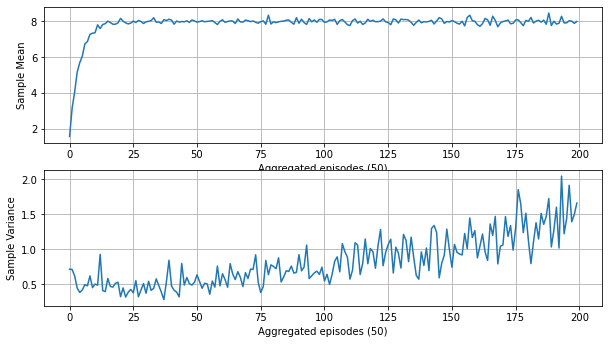

Annualized return: 23.09%
Standard deviation: 36.42%
Sharpe Ratio: 0.63


In [336]:
%matplotlib inline
# Mean of terminal wealth over 50 iterations
terminal_wealth = Result[0][2]
terminal_wealth_50 = np.mean(terminal_wealth.reshape(-1, 50), axis=1)

# Standard deviation of terminal wealthes over 50 iterations
Std_50 = np.var(terminal_wealth.reshape(-1, 50), axis=1)

##Plots
plt.rcParams["figure.figsize"] = (10,5.5)
# sample means
plt.subplot(2, 1, 1)
plt.plot(terminal_wealth_50)
plt.grid()
plt.xlabel("Aggregated episodes (50)")
plt.ylabel("Sample Mean")
# sample variances
plt.subplot(2, 1, 2)
plt.plot(Std_50)
#plt.yscale('log')
plt.grid()
plt.xlabel("Aggregated episodes (50)")
plt.ylabel("Sample Variance")
plt.show()

# Print
ann_return = np.mean(terminal_wealth[-2000:])**0.1-1
std_return = np.std(terminal_wealth[-2000:])/np.sqrt(10)
print('Annualized return: ' + str(round(ann_return*100,2)) + '%')
print('Standard deviation: ' + str(round(std_return*100,2)) + '%')
print('Sharpe Ratio: ' + str(round((ann_return)/std_return,2)))

# 6. Backtesting

## 6.1 Markowitz

In [229]:
datamark = data.iloc[:240]
wealth_Mark = np.zeros([100,241])

for i in range(0,100):
    np.random.seed(i*2)
    data_test = datamark.sample(n=20,axis='columns')
    
    class Config:
        lookback = 120
        calc_return_dict = {"method": "rolling"}
        calc_mean_return_dict = {"method": "arithmetic"}
        calc_moment_dict = {}
        calc_beta_dict = {}
        beta = data_test.columns.values.tolist()[0]
        objective = {"objective_type": "min_volatility"}
        constraints = [{"constraint_type": "expected_return", "bound": (1,7)}]
        
    strategy = WeighMarkowitz(Config) 


    # Personal Strategy
    s1 = bt.Strategy('s1', [bt.algos.RunMonthly(),
                       bt.algos.SelectAll(),
                       strategy,
                       bt.algos.Rebalance()])
    test1 = bt.Backtest(s1, data_test)
    res = bt.run(test1) 
    wealth_Mark[i,:] = res.prices.to_numpy().reshape((241,))

Markowitz = wealth_Mark[:,121:]

## 6.2 EMV 

### 6.2.1 Initialize

In [337]:
# Choose the Leverage constraint in percent:
Leverage = 200.
# Time horizon
T = 10.
# Time interval
dt = T/120
# Number of time intervals
T1 = int(np.floor(T/dt))
# Initial wealth
x0 = 1
# number of assets
d = 20
# Number of repetitions
N = 100
# Returns of testing window
D1 = Returns2.shape[1]

# Initialize vectors
wealth_EMV = np.zeros([N,120])
wealth_EMV_Lev = np.zeros([N,120])
wealth_EMV_Lev2 = np.zeros([N,120])
wealth_equal = np.zeros([N,120])
wealth_strat = np.zeros([N,120])
wealth_EMV[:,0] = x0
wealth_EMV_Lev[:,0] = x0
wealth_EMV_Lev2[:,0] = x0
wealth_equal[:,0] = x0

# Trained Mean Function with last 300 parameter average
mean = lambda x: -np.dot(inv(Result[0][4]),Result[0][5]*np.sqrt(2/d))*(x-Result[0][3])

#mean = Result[0][0]

### 6.2.2 Out-of-sample

In [338]:
np.random.seed(1)
for j in range(0,N):
    
    # Initialize wealth process
    x_EMV = x0
    x_EMV_Lev = x0
    x_EMV_Lev2 = x0
    x_equal = x0
    
    # Select randomly d stocks
    selected = np.random.choice(D1, d, replace=False)
    R = Returns2[:,selected]
    
    for i in range(1, T1):
        
            # Evaluate Allocation
            u_EMV = mean(float(x_EMV)) 
            u_EMV_Lev = mean(float(x_EMV_Lev))
            u_EMV_Lev2 = mean(float(x_EMV_Lev2))
            u_equal = np.repeat(1/d,d)
            
            # Leverage constraints
            u_EMV_Lev = u_EMV_Lev/np.linalg.norm(u_EMV_Lev,ord = 1)*x_EMV_Lev*Leverage/100
            u_EMV_Lev2 = u_EMV_Lev2/np.linalg.norm(u_EMV_Lev2,ord = 1)*x_EMV_Lev2
            
            wealth_strat[j,i] = np.linalg.norm(u_EMV,ord = 1)/x_EMV
            
            # Compute wealth
            x_EMV = x_EMV+float(np.dot(u_EMV,R[i-1,:]))
            x_EMV_Lev = x_EMV_Lev+float(np.dot(u_EMV_Lev,R[i-1,:]))
            x_EMV_Lev2 = x_EMV_Lev2+float(np.dot(u_EMV_Lev2,R[i-1,:]))
            x_equal = x_equal+float(np.dot(u_equal,R[i-1,:]))
            
            # Store values
            wealth_EMV[j,i] = x_EMV
            wealth_EMV_Lev[j,i] = x_EMV_Lev
            wealth_EMV_Lev2[j,i] = x_EMV_Lev2
            wealth_equal[j,i] = x_equal
            

In [339]:
# EMV
AR_EMV = np.mean(wealth_EMV[:,-1])**0.1-1
SD_EMV = np.std(wealth_EMV[:,-1])/np.sqrt(10)
SR_EMV = AR_EMV/SD_EMV
# EMV (L = 200%)
AR_EMV_L = np.mean(wealth_EMV_Lev[:,-1])**0.1-1
SD_EMV_L = np.std(wealth_EMV_Lev[:,-1])/np.sqrt(10)
SR_EMV_L = AR_EMV_L/SD_EMV_L
# EMV (L = 100%)
AR_EMV_L2 = np.mean(wealth_EMV_Lev2[:,-1])**0.1-1
SD_EMV_L2 = np.std(wealth_EMV_Lev2[:,-1])/np.sqrt(10)
SR_EMV_L2 = AR_EMV_L2/SD_EMV_L2
# Equally weighted
AR_equal = np.mean(wealth_equal[:,-1])**0.1-1
SD_equal = np.std(wealth_equal[:,-1])/np.sqrt(10)
SR_equal = AR_equal/SD_equal
#Markowitz
AR_M = np.mean(Markowitz[:,-1]/100)**0.1-1
SD_M = np.std(Markowitz[:,-1]/100)/np.sqrt(10)
SR_M = AR_M/SD_M


data_tabl = {'EMV':[str(round(AR_EMV*100,2))+'%', str(round(SD_EMV*100,2))+'%', str(round(SR_EMV,2))],
             'EMV (L = 200%)':[str(round(AR_EMV_L*100,2))+'%', str(round(SD_EMV_L*100,2))+'%', str(round(SR_EMV_L,2))],
            'EMV (L = 100%)':[str(round(AR_EMV_L2*100,2))+'%', str(round(SD_EMV_L2*100,2))+'%', str(round(SR_EMV_L2,2))],
            'Equal':[str(round(AR_equal*100,2))+'%', str(round(SD_equal*100,2))+'%', str(round(SR_equal,2))],
            'Markowitz':[str(round(AR_M*100,2))+'%', str(round(SD_M*100,2))+'%', str(round(SR_M,2))]}
 
# Create DataFrame
df = pd.DataFrame(data_tabl)
df.index = ['Return', 'Standard Deviation', 'Sharpe Ratio']
# Print the output.
df

,EMV,EMV (L = 200%),EMV (L = 100%),Equal,Markowitz
Return,23.19%,21.75%,13.28%,9.11%,9.92%
Standard Deviation,1.15%,43.9%,21.55%,5.43%,15.62%
Sharpe Ratio,20.12,0.5,0.62,1.68,0.64


## 6.3 Invested Wealth

<IPython.core.display.Javascript object>


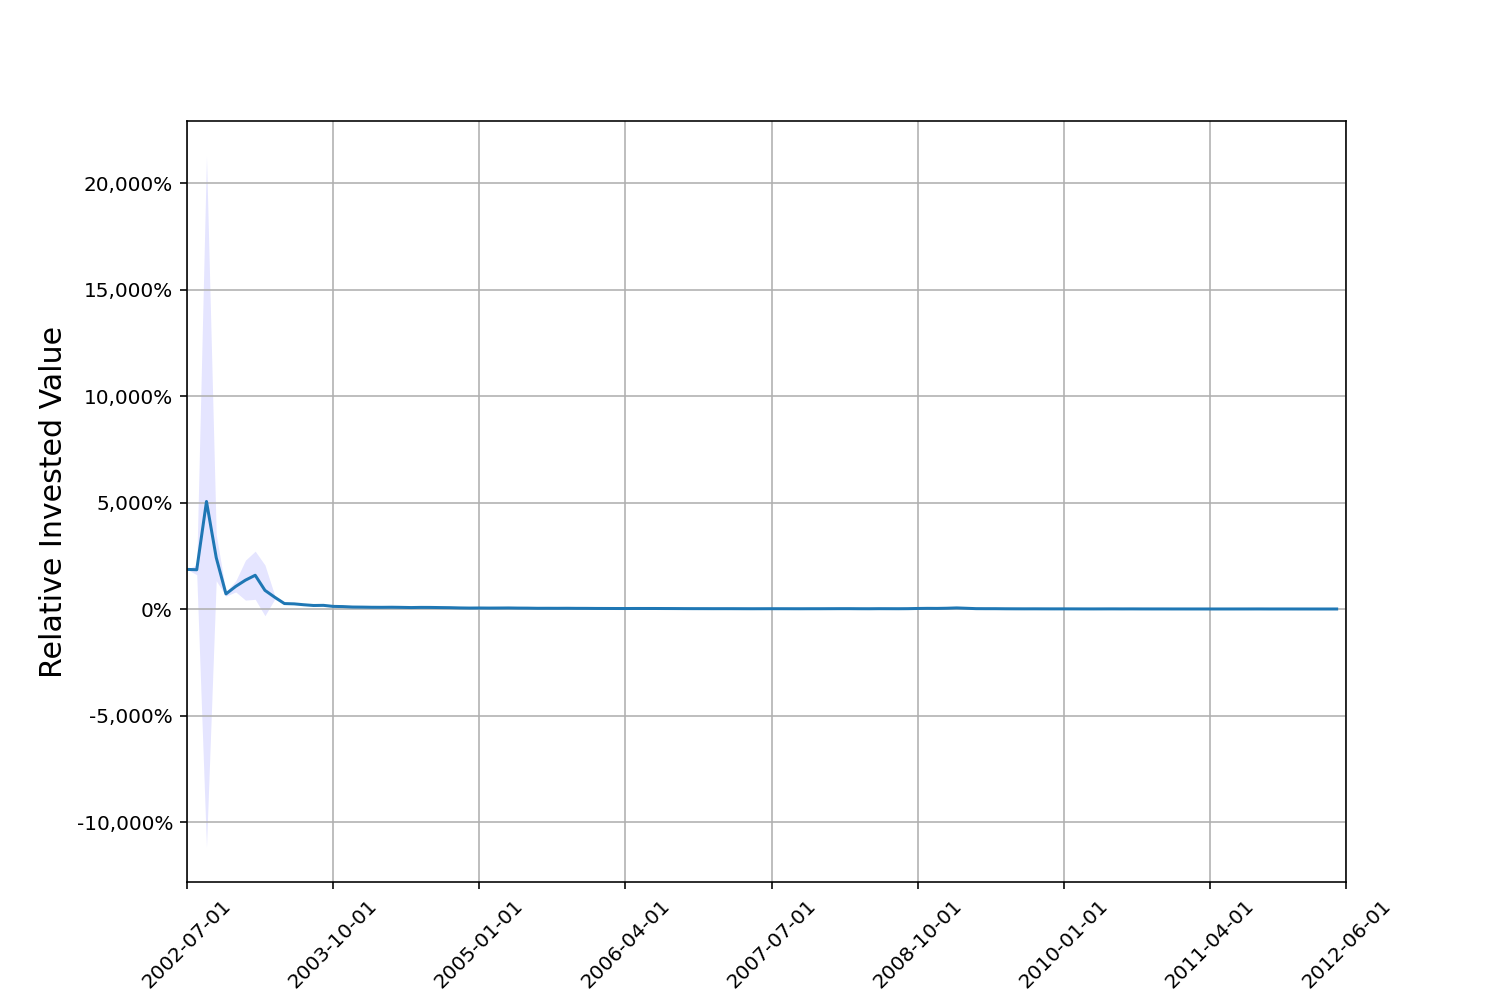

/var/folders/49/4kqg08kn0990xympcdr529dh0000gn/T/ipykernel_6432/649109717.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


In [340]:
%matplotlib notebook
fig, ax = plt.subplots()

# Relative invested capital
wealth_strat1 = wealth_strat[:,1:]
# Mean
wealth_strat_mean = np.mean(wealth_strat1,axis=0)
plt.plot(wealth_strat_mean)
# 95%-Confidence 
ci_stat = 1.96 * np.std(wealth_strat1,axis = 0)/np.sqrt(len(wealth_strat1[1,:]))
ax.fill_between(np.linspace(0,118,num=119),(wealth_strat_mean-ci_stat), (wealth_strat_mean+ci_stat), color='b', alpha=.1, linewidth=0)

# Plot
plt.ylabel('Relative Invested Value', fontsize=15)
ax.grid()
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
ax.set_xlim((0,119))
date = pd.Series(data2.index.format('%Y-%m-%d')).to_numpy()[1:]
date = [x.split()[0] for x in date]
dt = np.array(date)
dt = dt.tolist()
ax.set_xticks([0,15,30,45,60,75,90,105,119], np.take(dt,np.array([0,15,30,45,60,75,90,105,119])),rotation = 45)
plt.rcParams['figure.figsize'] = [10.4, 8.]
#plt.savefig('RIV'+  str(dt[0]) +'.png')

## 6.4 Portfolio-Wealth

<IPython.core.display.Javascript object>


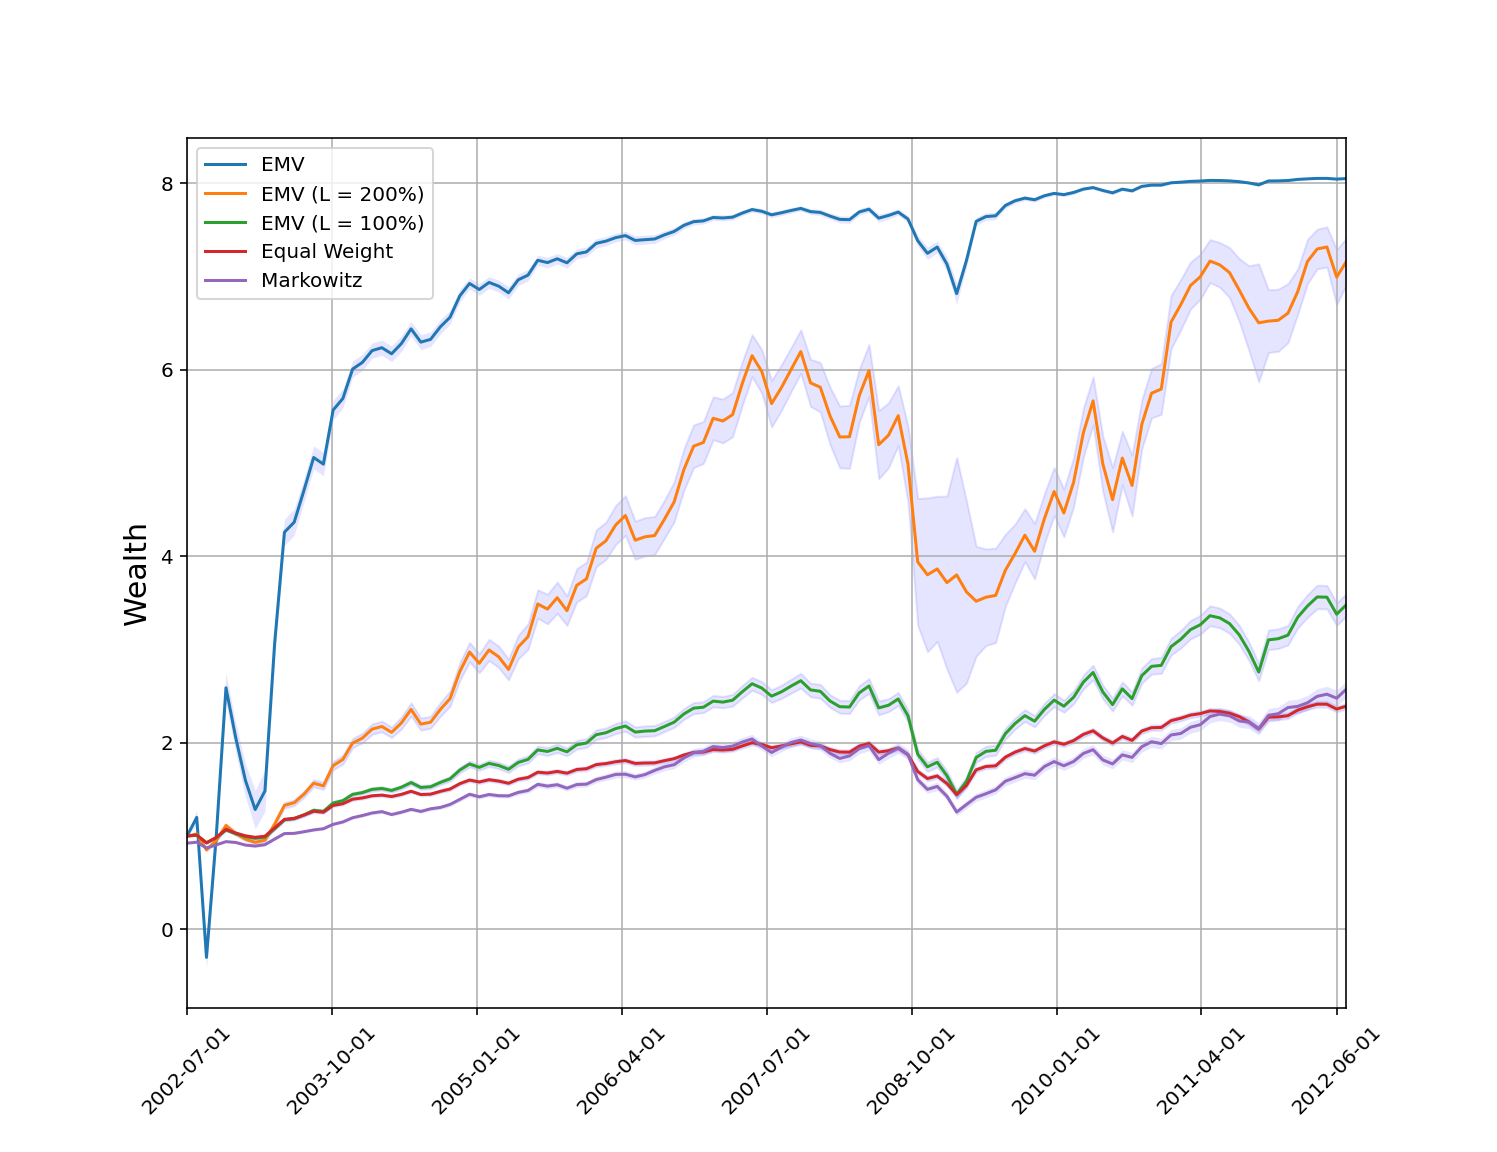

Text(0, 0.5, 'Wealth')

In [341]:
%matplotlib notebook

# x-axis
date = pd.Series(data2.index.format('%Y-%m-%d')).to_numpy()[1:]
date = [x.split()[0] for x in date]
dt = np.array(date)
dt = dt.tolist()

## EMV
# Mean
EMV_mean = np.mean(wealth_EMV,axis=0)
# 95%-Confidence interval
ci_EMV = 1.96 * np.std(wealth_EMV,axis = 0)/np.sqrt(len(wealth_EMV[1,:]))
# Plot
fig, ax = plt.subplots()
ax.set_xlim((0,120))
ax.plot(np.linspace(0,120,num=120),EMV_mean, label='EMV')
ax.fill_between(np.linspace(0,120,num=120),(EMV_mean-ci_EMV), (EMV_mean+ci_EMV), color='b', alpha=.1, linewidth=0)
ax.set_xticks([0,15,30,45,60,75,90,105,119], np.take(dt,np.array([0,15,30,45,60,75,90,105,119])),rotation = 45)
ax.grid()

## EMV with Leverage
# Mean
Lev_mean = np.mean(wealth_EMV_Lev,axis=0)
# 95%-Confidence interval
ci_Lev = 1.96 * np.std(wealth_EMV_Lev,axis = 0)/np.sqrt(len(wealth_EMV_Lev[1,:]))
# Plot
ax.plot(np.linspace(0,120,num=120),Lev_mean, label='EMV (L = 200%)')
ax.fill_between(np.linspace(0,120,num=120),(Lev_mean-ci_Lev), (Lev_mean+ci_Lev), color='b', alpha=.1)

## EMV with Leverage
# Mean
Lev_mean2 = np.mean(wealth_EMV_Lev2,axis=0)
# 95%-Confidence interval
ci_Lev2 = 1.96 * np.std(wealth_EMV_Lev2,axis = 0)/np.sqrt(len(wealth_EMV_Lev2[1,:]))
# Plot
ax.plot(np.linspace(0,120,num=120),Lev_mean2, label='EMV (L = 100%)')
ax.fill_between(np.linspace(0,120,num=120),(Lev_mean2-ci_Lev2), (Lev_mean2+ci_Lev2), color='b', alpha=.1)

## Equally weighted Portfolio
# Mean
equal_mean = np.mean(wealth_equal,axis=0)
# 95%-Confidence interval
ci_equal = 1.96 * np.std(wealth_equal,axis = 0)/np.sqrt(len(wealth_equal[1,:]))
# Plot
ax.plot(np.linspace(0,120,num=120),equal_mean, label='Equal Weight')
ax.fill_between(np.linspace(0,120,num=120),(equal_mean-ci_equal), (equal_mean+ci_equal), color='b', alpha=.1)

## Markowitz
# Mean
Mark_mean = np.mean(Markowitz,axis=0)/100
# 95%-Confidence interval
ci_Mark = 1.96 * np.std(Markowitz,axis = 0)/np.sqrt(len(Markowitz[1,:]))/100
# Plot
ax.plot(np.linspace(0,120,num=120),Mark_mean, label='Markowitz')
ax.fill_between(np.linspace(0,120,num=120),(Mark_mean-ci_Mark), (Mark_mean+ci_Mark), color='b', alpha=.1, linewidth=0)
ax.legend(loc = 'upper left')
plt.rcParams['figure.figsize'] = [10.4, 7.]
plt.ylabel('Wealth', fontsize=15)